In [1]:
import casadi
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
from matplotlib.animation import FuncAnimation

import ncsudyn

In [2]:
m, l, g = 1, 1, 9.8

# Define optimization variables
T = 5.0  # Time horizon
N = 100  # Number of control intervals
dt = T / N

# define dynamics
nq = 1
nv = 1
cq = casadi.SX.sym("q", nq)  # generalized position
cv = casadi.SX.sym("v", nv)  # generalized velocity
cu = casadi.SX.sym("u", nv)  # control input
aba_fn = casadi.Function("aba_fn", [cq, cv, cu], [cu - g / l * casadi.sin(cq)])


# Euler integrator
def euler_integrate(q, v, u):
    q_next = q + v * dt
    v_next = v + aba_fn(q, v, u) * dt
    return q_next, v_next

In [3]:
opti = casadi.Opti()

Q = opti.variable(nq, N + 1)
V = opti.variable(nv, N + 1)
U = opti.variable(nv, N)


# Set initial state
opti.subject_to(Q[:, 0] == np.array([0]))
opti.subject_to(V[:, 0] == np.array([0]))

# Set final state
opti.subject_to(Q[:, N] == np.array([np.pi]))
opti.subject_to(V[:, N] == np.array([0]))

# Set dynamics constraints
for k in range(N):
    q_next, v_next = euler_integrate(Q[:, k], V[:, k], U[:, k])
    opti.subject_to(Q[:, k + 1] == q_next)
    opti.subject_to(V[:, k + 1] == v_next)

# Set control limits
limit = 3.0
opti.subject_to(opti.bounded(-limit, U, limit))

# Define objective
obj = 0
for k in range(N):
    obj += U[:, k].T @ U[:, k]
    obj += (Q[:, k] - np.array([np.pi])) ** 2

opti.minimize(obj)

# Solve
opti.solver("ipopt")
sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.11.9, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      704
Number of nonzeros in inequality constraint Jacobian.:      100
Number of nonzeros in Lagrangian Hessian.............:      200

Total number of variables............................:      302
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

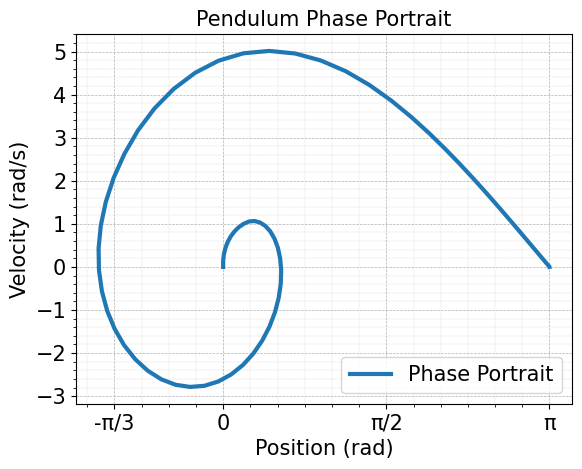

In [4]:
save_fig = True
font_size = 15

Q_traj = sol.value(Q)
V_traj = sol.value(V)

plt.plot(Q_traj, V_traj, linewidth=3, label="Phase Portrait")
plt.title("Pendulum Phase Portrait", fontsize=font_size)
plt.xlabel("Position (rad)", fontsize=font_size)
plt.ylabel("Velocity (rad/s)", fontsize=font_size)

# Set x-ticks to multiples of pi
xticks = np.array([-np.pi / 3, 0, np.pi / 2, np.pi])
plt.xticks(xticks, ["-π/3", "0", "π/2", "π"], fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.minorticks_on()
plt.grid(which="minor", linestyle=":", linewidth=0.3)

plt.legend(fontsize=font_size)

if save_fig:
    plt.savefig("pendulum_phase_portrait.png", bbox_inches="tight")

plt.show()

In [ ]:
fig = plt.figure(figsize=(5, 5), constrained_layout=False)

ax1 = fig.add_subplot(111)
(ln1,) = ax1.plot([], [], linewidth=5, color="lightblue")
(ln2,) = ax1.plot([], [], marker=".", ls="", markersize=30)

# plt.axis('off')
plt.tight_layout()

ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax1.set_aspect(1)

# Add grid lines
ax1.grid(which="both", linestyle="--", linewidth=0.5)
ax1.minorticks_on()
ax1.grid(which="minor", linestyle=":", linewidth=0.3)


def update(i):
    q = Q_traj[i]
    x_start = [0, l * np.sin(q)]
    y_start = [0, -l * np.cos(q)]
    ln1.set_data(x_start, y_start)

    x_start = x_start[1:]
    y_start = y_start[1:]
    ln2.set_data(x_start, y_start)


anim = FuncAnimation(fig, update, range(N), interval=dt * 1000)

print("Generating animation...")
plt.close()
html = HTML(anim.to_jshtml())
print("Done!")
display(html)

### Using ncsudyn

In [6]:
class PendulumDynamics(ncsudyn.core.dynamics.Dynamics):
    def __init__(self, m, l, g):
        self.m = m
        self.l = l
        self.g = g
        self.nq = 1
        self.nv = 1
        self.nu = 1

        cq = casadi.SX.sym("q", self.nq)  # generalized position
        cv = casadi.SX.sym("v", self.nv)  # generalized velocity
        cu = casadi.SX.sym("u", self.nu)  # control input
        self.aba_fn = casadi.Function("aba_fn", [cq, cv, cu], [cu - self.g / self.l * casadi.sin(cq)])

    def get_value(self, q, v, u):
        return self.aba_fn(q, v, u)


class PendulumCost(ncsudyn.core.cost.IntermediateCost):
    def is_active(self, time):
        return True

    def get_value(self, Qs, Vs, Us, time, dt, idx):
        q = Qs[:, idx]
        v = Vs[:, idx]
        u = Us[:, idx]
        return casadi.sumsqr(q - np.pi) + casadi.sumsqr(v) + 120.1 * casadi.sumsqr(u)


class PendulumInitialConstraint(ncsudyn.core.constraint.InitialConstraint):
    def get_value(self, Qs, Vs, Us, time, dt, idx):
        return [Qs[:, idx] == 0, Vs[:, idx] == 0]


class PendulumFinalConstraint(ncsudyn.core.constraint.FinalConstraint):
    def get_value(self, Qs, Vs, time, dt, idx):
        return [Qs[:, idx] == np.pi, Vs[:, idx] == 0]


class PendulumControlConstraint(ncsudyn.core.constraint.IntermediateConstraint):
    def is_active(self, time):
        return True

    def get_value(self, Qs, Vs, Us, time, dt, idx):
        limit = 3
        return [Us[:, idx] <= limit, Us[:, idx] >= -limit]

In [ ]:
m, l, g = 1, 1, 9.8
dynamics = PendulumDynamics(m, l, g)
options = ncsudyn.core.optimize.TrajectoryOptimizerOptions(T=5, dt=0.05, nq=dynamics.nq, nv=dynamics.nv, nu=dynamics.nu)
optimizer = ncsudyn.core.optimize.TrajectoryOptimizer(options)

optimizer.add_dynamics(dynamics)
optimizer.add_intermediate_cost(PendulumCost())
optimizer.add_intermediate_constraint(PendulumControlConstraint())
optimizer.add_initial_constraint(PendulumInitialConstraint())
optimizer.add_final_constraint(PendulumFinalConstraint())

trajectory = optimizer.optimize()

In [ ]:
fig = plt.figure(figsize=(5, 5), constrained_layout=False)

ax1 = fig.add_subplot(111)
(ln1,) = ax1.plot([], [], linewidth=5, color="lightblue")
(ln2,) = ax1.plot([], [], marker=".", ls="", markersize=30)

# plt.axis('off')
plt.tight_layout()

ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax1.set_aspect(1)

# Add grid lines
ax1.grid(which="both", linestyle="--", linewidth=0.5)
ax1.minorticks_on()
ax1.grid(which="minor", linestyle=":", linewidth=0.3)


def update(i):
    q = trajectory.Q_traj[i]
    x_start = [0, l * np.sin(q)]
    y_start = [0, -l * np.cos(q)]
    ln1.set_data(x_start, y_start)

    x_start = x_start[1:]
    y_start = y_start[1:]
    ln2.set_data(x_start, y_start)


anim = FuncAnimation(fig, update, range(len(trajectory.Q_traj)), interval=dt * 1000)

print("Generating animation...")
plt.close()
html = HTML(anim.to_jshtml())
print("Done!")
display(html)